In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from LSTM_model import LSTM
#from LSTM_model import DLSTM



from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score
)

In [2]:
from PyEMD import EMD
from scipy.signal import hilbert


In [3]:

file_path = '../../data/dataS.csv'
df = pd.read_csv(file_path, parse_dates=['Date'])
df.sort_values('Date', inplace=True, ignore_index=True)

features = ['volatility']
target   = 'volatility_forcast'
data_X   = df[features].values
data_y   = df[[target]].values

In [4]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(data_X)
y_scaled = scaler_y.fit_transform(data_y)


In [5]:
def dynamic_error_windows(X, max_window):
    N = len(X)
    tau = np.ones(N, dtype=int)
    for t in range(N):
        w_max = min(max_window, t)
        if w_max < 1:
            tau[t] = 1
            continue
        errs = [
            (X[t-w:t].mean() - X[t])**2
            for w in range(1, w_max+1)
        ]
        tau[t] = np.argmin(errs) + 1
    return tau


df = pd.read_csv('../../data/datav.csv')
X = df['volatility'].values
N = len(X)

max_W = 100
N = len(X)

emd = EMD()
imfs = emd.emd(X)
all_amp = []
for imf in imfs:
    asig = hilbert(imf)
    all_amp.append(np.abs(asig))

all_pow = [amp**2 for amp in all_amp]
energies = [p.mean() for p in all_pow]

inst_power_norm = np.zeros_like(X, dtype=float)
for p, E in zip(all_pow, energies):
    inst_power_norm += (p / E)

tau_emd = np.clip(np.round(inst_power_norm).astype(int), 1, max_W)


print("first 20 EMD‐windows:",         tau_emd[:20])


first 20 EMD‐windows: [24 16 16 15 12 11 11 10 10  9  9  9 10 11 10  9 11 11  9  9]


In [6]:
def create_sequences(X, y, seq_length):
    Xs, ys = [], []
    for i in range(len(X) - seq_length):
        Xs.append(X[i : i + seq_length])
        ys.append(y[i + seq_length])
    return np.array(Xs), np.array(ys)


#seq_length = 5
#X_seq, y_next = create_sequences(X_scaled, y_scaled, seq_length)


In [ ]:
def create_dynamic_sequences(X, y, tau, max_len):
    Xs, ys, idx = [], [], []
    T, D = X.shape
    for t in range(T):
        w = tau[t]
        if t < w:
            continue

        window = X[t-w:t]            # shape (w, D)

        if w < max_len:
            pad = np.zeros((max_len - w, D), dtype=X.dtype)
            window = np.vstack([pad, window])

        Xs.append(window)
        ys.append(y[t])
        idx.append(t)

    return np.stack(Xs), np.stack(ys), np.array(idx)



In [ ]:
max_W = tau_emd.max()

X_dyn, y_dyn, keep_idx = create_dynamic_sequences(
    X_scaled,       # (T, D)
    y_scaled,       # (T,) or (T,1)
    tau_emd,        # (T,)
    max_W           # scalar
)

print("X_dyn shape:", X_dyn.shape)  # (N, max_W, D)
print("y_dyn shape:", y_dyn.shape)  # (N,) or (N,1)


X_dyn shape: (5360, 100, 1)
y_dyn shape: (5360, 1)


In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X_dyn, y_dyn,
    test_size=0.2,
    shuffle=False,
)

In [10]:
def build_y_seqs(y_flat, seq_length):
    N = len(y_flat)
    y_seqs = np.zeros((N, seq_length, 1), dtype=float)
    for i in range(N):
        y_seqs[i, :, 0] = y_flat[i]
    return y_seqs

Y_train = build_y_seqs(y_train, max_W)
Y_test  = build_y_seqs(y_test, max_W)


In [ ]:
model = LSTM(
    input_dim = X_train.shape[2],
    hidden_dim= 64,
    output_dim= 1,
    lr        = 1e-3
)

model.train(
    X_train, Y_train,
    epochs     = 100,
    batch_size = 32,
    val_data   = (X_test, Y_test)
)

Epoch 1/100 — train MSE: 0.0072 — val MSE: 0.0053
Epoch 2/100 — train MSE: 0.0067 — val MSE: 0.0056
Epoch 3/100 — train MSE: 0.0067 — val MSE: 0.0054
Epoch 4/100 — train MSE: 0.0067 — val MSE: 0.0056
Epoch 5/100 — train MSE: 0.0066 — val MSE: 0.0062
Epoch 6/100 — train MSE: 0.0066 — val MSE: 0.0054
Epoch 7/100 — train MSE: 0.0064 — val MSE: 0.0058
Epoch 8/100 — train MSE: 0.0062 — val MSE: 0.0055
Epoch 9/100 — train MSE: 0.0062 — val MSE: 0.0055
Epoch 10/100 — train MSE: 0.0062 — val MSE: 0.0056
Epoch 11/100 — train MSE: 0.0061 — val MSE: 0.0053
Epoch 12/100 — train MSE: 0.0061 — val MSE: 0.0056
Epoch 13/100 — train MSE: 0.0061 — val MSE: 0.0054
Epoch 14/100 — train MSE: 0.0060 — val MSE: 0.0056
Epoch 15/100 — train MSE: 0.0061 — val MSE: 0.0054
Epoch 16/100 — train MSE: 0.0064 — val MSE: 0.0054
Epoch 17/100 — train MSE: 0.0067 — val MSE: 0.0057
Epoch 18/100 — train MSE: 0.0062 — val MSE: 0.0055
Epoch 19/100 — train MSE: 0.0061 — val MSE: 0.0058
Epoch 20/100 — train MSE: 0.0060 — val M

In [12]:
preds_seq = model.predict(X_test)         # shape (N_test, seq_length, 1)
preds_last = preds_seq[:, -1, 0]
y_last     = y_test[:, 0]

preds_inv = scaler_y.inverse_transform(preds_last.reshape(-1,1)).flatten()
y_inv     = scaler_y.inverse_transform(y_last.reshape(-1,1)).flatten()

mse   = mean_squared_error(y_inv, preds_inv)
rmse  = np.sqrt(mse)
mae   = mean_absolute_error(y_inv, preds_inv)
mape  = mean_absolute_percentage_error(y_inv, preds_inv)
r2    = r2_score(y_inv, preds_inv)


print("\nFinal Test Metrics:")
print(f"  MSE : {mse:.6f}")
print(f"  RMSE: {rmse:.6f}")
print(f"  MAE : {mae:.6f}")
print(f"  MAPE: {mape:.2%}")
print(f"  R²  : {r2:.4f}")


Final Test Metrics:
  MSE : 0.003752
  RMSE: 0.061256
  MAE : 0.049186
  MAPE: 97.64%
  R²  : 0.3201


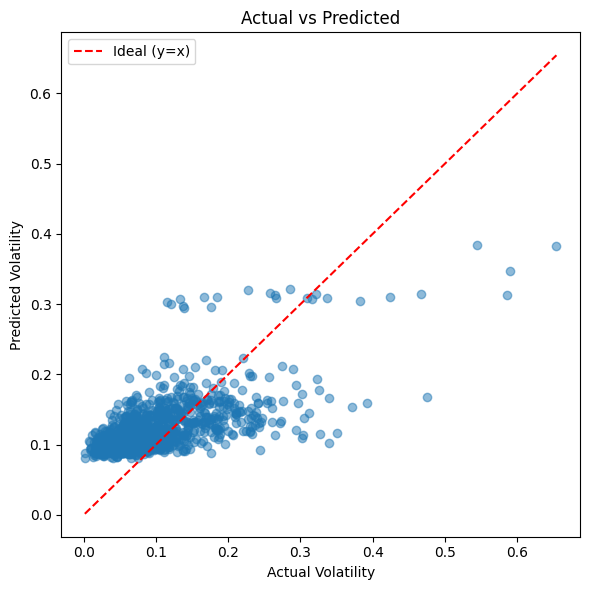

In [13]:
preds_seq = model.predict(X_test)        # (N_test, seq_len, 1)
preds_last = preds_seq[:, -1, 0]
y_last     = y_test[:, 0]

preds_inv = scaler_y.inverse_transform(preds_last.reshape(-1,1)).flatten()
y_inv     = scaler_y.inverse_transform(y_last.reshape(-1,1)).flatten()

plt.figure(figsize=(6,6))
plt.scatter(y_inv, preds_inv, alpha=0.5)
lims = [
    min(y_inv.min(), preds_inv.min()),
    max(y_inv.max(), preds_inv.max())
]
plt.plot(lims, lims, 'r--', label='Ideal (y=x)')
plt.xlabel('Actual Volatility')
plt.ylabel('Predicted Volatility')
plt.title('Actual vs Predicted')
plt.legend()
plt.tight_layout()
plt.show()

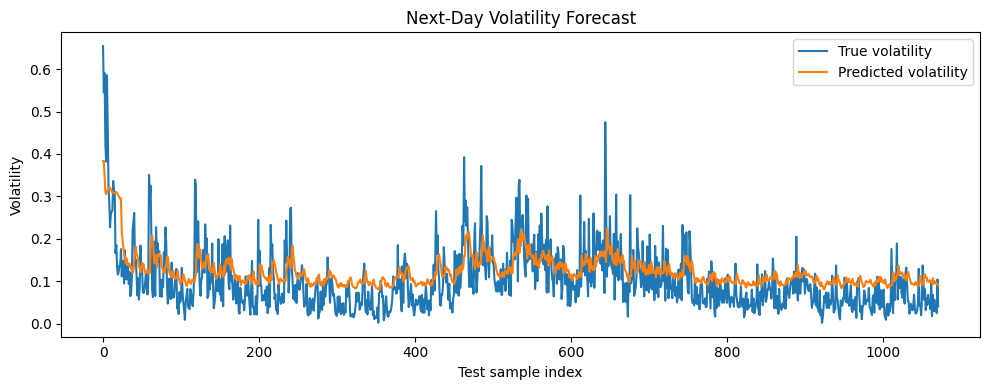

In [14]:
plt.figure(figsize=(10,4))
plt.plot(y_inv,    label='True volatility')
plt.plot(preds_inv, label='Predicted volatility')
plt.title('Next-Day Volatility Forecast')
plt.xlabel('Test sample index')
plt.ylabel('Volatility')
plt.legend()
plt.tight_layout()
plt.show()